# IRA Tweets: Analysis on Italian Tweets



In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
from zipfile import ZipFile
import json
import folium

import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests

from branca.element import Template, MacroElement

from folium import IFrame
from geopy.geocoders import Nominatim
import base64

from IPython.display import Image

# Introduction

### For the social good

The phenomenon of Russian IRA trolls has taken centre stage in the last months, casting a shadow on our understanding of the mechanisms which move social network discussions and debates in general.

In the last months we have started to be aware of the fact that Russian agencies have been using fake Twitter accounts to influence political results and manipulate people's opinions. In a period of political instability due to the economic crisis and the challenges that Western States are facing, it is all the more interesting to try to understand what are the means by which IRA acts to exacerbates the weaknesses of our society, by supporting populist parties and stressing the conflicts which characterise our countries.

Unless caution is not paid, we run the risk of some external entity imposing a certain mindset, orienting the political debate and pushing a particular point of view on delicate issues. Investigate the behaviour of Russian trolls means to foster informed and independent decisions, not spurred by heated online debates.

The focus of this analysis is on the Italian tweets of IRA, which have not yet been a specific object of study. We want to see if and how the action of trolls adapts to the specific Italian situation, and to do so we start by providing an overview of the Italian scenario.  

### Italian political context

Italy is nowadays seen as one of the weakest economies of the Eurozone, with high levels of unemployment and growth rates which fail to keep up with those of other countries. Its politics is particularly unstable and the electoral system fails to give rise to lasting governments and stable majorities, so that elections are frequent and the number of prime ministers in the last two decades is unrivalled, 14 in the last 24 years.

The political equilibrium has shifted towards less traditional parties following the economic crisis and the fall of Silvio Berlusconi, who has been the most stable political figure since 1994. The main parties at the moment are:

1. The **Democratic Party** (PD), a centre-left party which lacks a strrong leadership after Matteo Renzi lost popularity following a defeat in the 2006 constitutional referendum. Matteo Renzi has been secretary of the party from 2014 to 2016 and Prime Minister during the same years.

2. The **League**. Formerly known as the Northern League, a party supporting the independence of Northern Italy, the right-wing League set itself more national ambitions. It is a populist party, and currently the main party in the country, as well as the member of the coalition government together with M5S. Its key points are migration and the challenge of European rigidities in terms of budget limitations.

3. The **Five-Star Movement** (M5S) is a populist party, which aims at tackling social inequalities and fighting political privileges.

Both the League and the M5S hold eurosceptic positions, blaming the crisis on the common currency, the big financial institutions and the little flexibility available within the agreements of the European Union.

As many political commentators have stressed, a government formed by the M5S and the League is a threat to the stability of the Eurozone, and this is the reason why Russia, whose political ambitions are in conflict with those of the EU, might have all the interests to support it.

# 1. Data Reading and Exploration

### Reading the data

Data available:

1. a first version of the IRA tweets available [here](https://www.ka...-troll-tweets) ;

2. an updated collection of the IRA tweets which can be found [here](https://about.twitter.com/en_us/values/elections-integrity.html#data).

In the reading phase we read both the input data (corresponding to two zip files), we extract the italian tweets and we preprocess them. Finally, we store the result into two new csv files so as to be able to easily access the set of tweets we are interested in. 

We also store a csv file with the US tweets, for a future comparison of how differently trolls act in the case of the US and Italy. 

First we iterate through "russian-troll-tweets.zip" to read through every .csv file:

In [11]:
# Read the first IRA dataset
data_folder = './data/'

In [2]:
zip_file = ZipFile(data_folder+'russian-troll-tweets.zip')
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [3]:
fs['IRAhandle_tweets_1.csv'].head(2)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll


We append all datasets together in one DataFrame:

In [4]:
data=pd.DataFrame()
for key,val in fs.items():
    data=pd.concat([data,val])

In [5]:
data.describe()

,external_author_id,following,followers,updates,new_june_2018,retweet
count,2.973367e+06,2.973371e+06,2.973371e+06,2.973371e+06,2.973371e+06,2.973371e+06
mean,1.296128e+17,3.433524e+03,7.018913e+03,1.049756e+04,2.078735e-01,4.408955e-01
std,3.036341e+17,5.609881e+03,1.458463e+04,1.768729e+04,4.057859e-01,4.964945e-01
min,3.497640e+07,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,1.930748e+09,3.270000e+02,3.200000e+02,1.787000e+03,0.000000e+00,0.000000e+00
50%,2.581835e+09,1.499000e+03,1.274000e+03,4.333000e+03,0.000000e+00,0.000000e+00
75%,3.254274e+09,4.730000e+03,1.060000e+04,1.234100e+04,0.000000e+00,1.000000e+00
max,9.812510e+17,7.621000e+04,2.512760e+05,1.661130e+05,1.000000e+00,1.000000e+00


Here we preprocess the data, we notice that *content*, the main attribute of our analysis, has some null values. We prefer to keep them.

In [6]:
data.isnull().any()

external_author_id     True
author                False
content                True
region                 True
language              False
publish_date          False
harvested_date        False
following             False
followers             False
updates               False
post_type              True
account_type           True
new_june_2018         False
retweet               False
account_category      False
dtype: bool

We select only the italian tweets from the first. Finally we remove tweets whose region in United States since we are not interest in them. 

In [7]:
# Italian tweets
italian_tweets = data[data.language == 'Italian']

# Italian tweets and not USA region
italian_tweets_notusa = italian_tweets[italian_tweets.region != 'United States']

In [8]:
italian_tweets.to_csv("italian_tweets_old.csv")
italian_tweets_notusa.to_csv("italian_tweets_old_notusa.csv")

We also import from the second dataset ('ira_tweets_new.zip') and we repeat the previous analysis:

In [9]:
%%capture
# Read the second IRA dataset
zip_file = ZipFile(data_folder+'ira_tweets_new.zip')
interesting = ['rus_troll_tweet_text.csv',
               'rus_troll_tweet_stats.csv',
               'rus_troll_tweet_metadata.csv']
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename in interesting}

In [10]:
datanew=pd.DataFrame()
for key,val in fs.items():
    datanew=pd.concat([datanew,val], axis=1, sort=False)

In [11]:
datanew.isnull().any()

tweetid                 False
userid                  False
tweet_time              False
in_reply_to_tweetid      True
in_reply_to_userid       True
quoted_tweet_tweetid     True
is_retweet              False
retweet_userid           True
retweet_tweetid          True
quote_count             False
reply_count             False
like_count              False
retweet_count           False
hashtags                 True
urls                     True
user_mentions            True
poll_choices             True
tweetid                 False
tweet_language           True
tweet_text               True
tweetid                 False
follower_count          False
following_count         False
latitude                 True
longitude                True
tweet_client_name        True
dtype: bool

In [13]:
data4 = pd.read_csv(zip_file.open('rus_troll_user.csv'))
italian_tweets = datanew[datanew.tweet_language == 'it']
italian_tweets = pd.merge(italian_tweets, data4, on ='userid')
italian_tweets_notestados = italian_tweets.loc[italian_tweets['user_reported_location'] != 'Estados Unidos']
italian_tweets.to_csv("italian_tweets.csv")
italian_tweets_notestados.to_csv("italian_tweets_notestados.csv")
italian_tweets.head(2)

,tweetid,userid,tweet_time,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,quote_count,...,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,account_creation_date,account_language,follower_count_y,following_count_y,last_tweet_at
0,841607500931584000,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10,NaN,NaN,NaN,True,95217122,8.416069e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
1,842354395077533696,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38,NaN,NaN,NaN,True,100185915,8.423537e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35


In [13]:
stopwords = pd.read_json(data_folder + 'stopwords-it.json')
stopwords = stopwords[0].tolist()

### Authors: following and followers

> The idea in this part is to show the popolarity of the authors, according to the number of following/followers they have. We want to see if trolls use a specific strategy, for instance if they are extremely prolific or tend to keep low-key profiles.

We retrieve the two files created.

In [2]:
italian_tweets = pd.read_csv('italian_tweets_notestados.csv')
italian_tweets_old = pd.read_csv('italian_tweets_old_notusa.csv')

We modify the structure of the new dataset to match the previous one on the columns of interest. The idea is to create a dataset which can be used in the next parts.

In [3]:
italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')
italian_tweets['is_retweet']=italian_tweets['is_retweet'].apply(lambda x: 1*x)
italian_tweets=italian_tweets.rename(index=str, columns={"user_display_name":"author",
                                                         "follower_count_x": "followers",
                                                         "following_count_x": "following",
                                                         "tweet_time":"time",
                                                         "is_retweet":"retweet",
                                                         "tweet_language":"language"})
italian_tweets_old=italian_tweets_old.rename(index=str, columns={"publish_date":"time"})
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})

In [4]:
ita_tweets=pd.concat([italian_tweets[['author','followers','following','time','retweet','content','language']],
           italian_tweets_old[['author','followers','following','time','retweet','content','language']]])
no_retweets=ita_tweets[ita_tweets.retweet==0]
no_retweets=no_retweets.drop_duplicates(subset ='content')
retweets=ita_tweets[ita_tweets.retweet==1]
ita_tweets=pd.concat([no_retweets,retweets])

ita_tweets.to_csv('final_df.csv')

# Control if everything is fine
print(ita_tweets.shape)

(34015, 7)


We calculate for each author the maximum number of following/followers by taking a group by on author and computing the maximum. We calculate the average in a similar way. Finally we plot the result in logarithmic scale.

In [27]:
# Retrieve the data
followers=ita_tweets[['author','followers','time']]

# Group by author and calculate max
followers=followers.groupby('author').agg({'followers': 'max'}).rename(columns={'followers':'max_followers'})

# Retrieve the data
following=ita_tweets[['author','following','time']]

# Group by author and calculate max
following=following.groupby('author').agg({'following': 'max'}).rename(columns={'following':'max_following'})

In [28]:
# Retrieve the data
avgfollowers=ita_tweets[['author','followers','time']]

# Group by author and calculate mean
avgfollowers=avgfollowers.groupby('author').agg({'followers': 'mean'}).rename(columns={'followers':'mean_followers'})

# Retrieve the data
avgfollowing=ita_tweets[['author','following','time']]

# Group by author and calculate mean
avgfollowing=avgfollowing.groupby('author').agg({'following': 'mean'}).rename(columns={'following':'mean_following'})

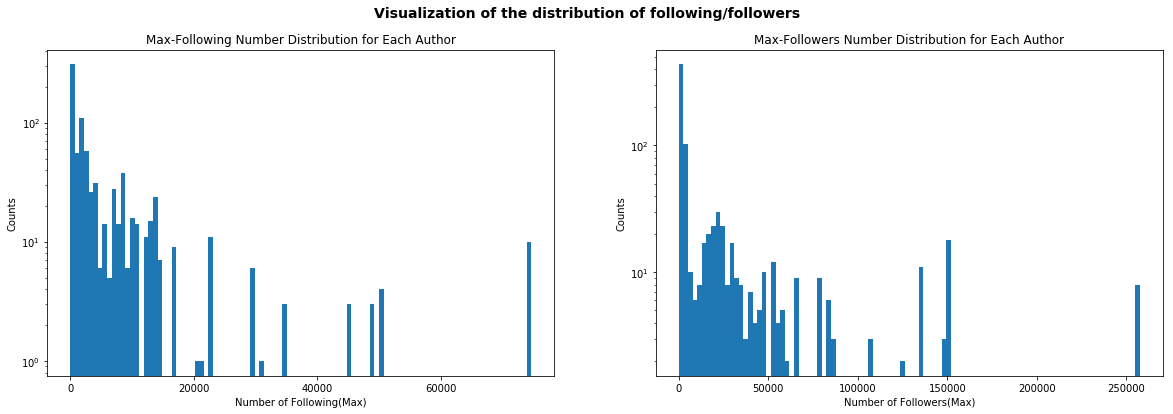

In [29]:
# Plot results
fig=plt.figure(figsize=(20,6))
fig.suptitle('Visualization of the distribution of following/followers', fontsize=14, fontweight='bold')

ax = fig.add_subplot(121)
ax.hist(following.max_following,bins=100,log=True)
ax.set_xlabel('Number of Following(Max)')
ax.set_ylabel('Counts')
ax.set_title(r'Max-Following Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

ax2 = fig.add_subplot(122)
ax2.hist(followers.max_followers,bins=100,log=True)
ax2.set_xlabel('Number of Followers(Max)')
ax2.set_ylabel('Counts')
ax2.set_title(r'Max-Followers Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

plt.show()

We look further into this by zooming in on relatively smaller account: the following analysis aims at showing that the number of followers and following is quite balanced. However, we remark that the plots show that in general, trolls have more followers than they do have following.

In [30]:
counters=ita_tweets.groupby('author').count()
less_following = following.loc[following['max_following'] < 20000]
less_followers = followers.loc[followers['max_followers'] < 50000]

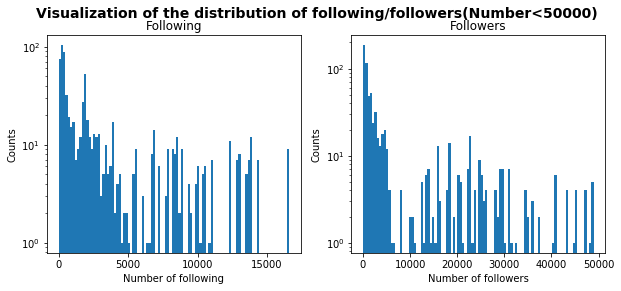

In [31]:
# Plot the results
fig=plt.figure(figsize=(10,4))
fig.suptitle('Visualization of the distribution of following/followers(Number<50000)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(121)

ax.hist(less_following.max_following,bins=100, log=True)
ax.set_xlabel('Number of following')
ax.set_ylabel('Counts')
ax.set_title(r'Following')
plt.locator_params(axis='x',nbins=4)

ax2 = fig.add_subplot(122)
ax2.hist(less_followers.max_followers,bins=100,log=True)
ax2.set_xlabel('Number of followers')
ax2.set_ylabel('Counts')
ax2.set_title(r'Followers')

plt.show()

> The large numbers we see -the number of author with a certain number of following/followers is relatively high- confirm us that the phenomenon of Russian trolls is quite widespread. As we could expect the number of followers tends to be higher than the number of people being followed by trolls. This suggest that there is an interest in their messages being heard.

### Authors: activity

In [8]:
# Retrieve the data
authors=ita_tweets[['content','author','time']]

# Control retweet
#dupli=authors.groupby(authors.content).size().reset_index().rename(columns={0:'nums'})
#dupli=dupli[dupli.nums>1]
#dupli

Here we count the total number of all contents:

In [9]:
authors.content.count()

34015

In [10]:
authors.dtypes

content            object
author             object
time       datetime64[ns]
dtype: object

In [11]:
authors['time']=authors['time'].apply(lambda x: x.date())#Only keep the date

#Count total number of tweets the author sent out in one day:
authors=authors.groupby(['author','time']).agg('count').rename(columns={'content':'tot'})

#Take the average number of tweets one author sent out per day:
authors=authors.groupby(by='author',as_index=True).agg({'tot':'mean'}).reset_index().rename(columns={'tot':'avg'})

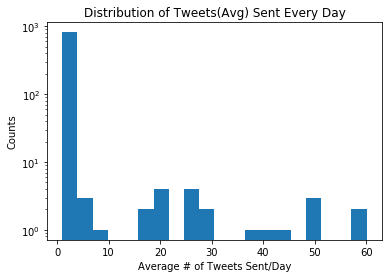

In [12]:
# Plot the results
plt.hist(authors.avg, log=True, bins=20)
plt.xlabel('Average # of Tweets Sent/Day')
plt.ylabel('Counts')
plt.title(r'Distribution of Tweets(Avg) Sent Every Day')
plt.show()

In [13]:
tweets=ita_tweets[['content','author','time']]
tweets.describe()

,content,author,time
count,34015,34015,34015
unique,31682,839,16484
top,RT @mrd125: Auto-Tune #MustBeBanned,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-29 15:17:00
freq,18,3637,12
first,NaN,NaN,2011-02-01 21:16:00
last,NaN,NaN,2017-12-09 22:49:00


In [14]:
# Select authors whose average is higher than 20 and store it
prolific=authors.loc[authors.avg>20]
tweets_prolific=tweets.copy().merge(prolific,how='right',on='author')
tweets_prolific=tweets_prolific[tweets_prolific['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]
tweets_prolific.head(2)
num_prolific=tweets_prolific.size
num_tweets=tweets.size
tweets_prolific.head(1)
#tweets.describe()

,content,author,time,avg
0,Mi sono ricordata che oggi è l'otto di marzo s...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-08 15:24:00,59.622951


Conclusion

> Troll authors display different behaviours in terms of popularity and activity, which conveys the idea that they aim at targeting different people. While some of them are extremely prolific, some others have a more low-key profile. 

### Italian politicians

Here we focus on analyzing the frequency of several important italian politicians when they were mentioned in tweets. We try to find their appearance frequency in all tweets and in tweets with prolific authors separately. We want to see if prolific authors are more involved in political issues among the troll accounts, i.e. if the most active accounts are actively pushing the debate towards more political subjects.

As an aside, notice that the analysis was performed starting from 2017, since Salvini's popularity in the country started soar around that period. It would be less meaningful to include previous years in the queries.

In [15]:
#First we filter the tweets and only keep contents which are sent after 2017.01.01
tweets_2017=tweets[tweets['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]
prolific_2017=tweets_prolific[tweets_prolific['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]

In [43]:
renzi=prolific_2017[prolific_2017['content'].apply(lambda x: 'renzi' in x.lower())]
mentions1=renzi.content.count()
print("'Renzi' mentioned in tweets_prolific:", mentions1, "times")

'Renzi' mentioned in tweets_prolific: 491 times


In [44]:
renzi=tweets_2017[tweets_2017['content'].apply(lambda x: 'renzi' in x.lower())]
mentions2=renzi.content.count()
print("'Renzi' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Renzi' mentioned in all tweets: 633 times
Mentions by prolific authors: 0.78


Matteo Renzi is an Italian politician who served as the Prime Minister of Italy from February 2014 until December 2016(from wikipedia). From above data, he was mentioned 491 times in tweets with prolific authors, and 633 times in all tweets.

In [45]:
salvini=prolific_2017[prolific_2017['content'].apply(lambda x: 'salvini' in x.lower())]
mentions1=salvini.content.count()
print("'Salvini' mentioned in tweets_prolific:", mentions1, "times")

'Salvini' mentioned in tweets_prolific: 149 times


In [46]:
salvini=tweets_2017[tweets_2017['content'].apply(lambda x: 'salvini' in x.lower())]
mentions2=salvini.content.count()
print("'Salvini' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Salvini' mentioned in all tweets: 192 times
Mentions by prolific authors: 0.78


Matteo Salvini has also been Federal Secretary of Northern League since December 2013 and the leader of Us with Salvini since December 2014(from wikipedia). From above data, he was mentioned 149 times in tweets with prolific authors, and 192 times in all tweets.

In [47]:
grillo=prolific_2017[prolific_2017['content'].apply(lambda x: 'grillo' in x.lower())]
mentions1=grillo.content.count()
print("'Grillo' mentioned in tweets_prolific:", mentions1, "times")

'Grillo' mentioned in tweets_prolific: 140 times


In [48]:
grillo=tweets_2017[tweets_2017['content'].apply(lambda x: 'grillo' in x.lower())]
mentions2=grillo.content.count()
print("'Grillo' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Grillo' mentioned in all tweets: 166 times
Mentions by prolific authors: 0.84


Beppe Grillo has been involved in politics since 2009 as the co-founder (together with Gianroberto Casaleggio) of the Italian Five Star Movement political party(from wikipedia). From above data, he was mentioned 140 times in tweets with prolific authors, and 166 times in all tweets.

In [ ]:
ments=pd.read_excel('./data/ments.xlsx',header=0)
ments

In [ ]:
plt.rcParams.update({'font.size': 18})
ments.plot.bar(color=['#3399FF', 'black'],title='Mentions of Italian Politicians')
plt.savefig('poli_ments.png')
plt.show()

In [49]:
lega=prolific_2017[prolific_2017['content'].apply(lambda x: 'lega' in x.lower())]
mentions1=lega.content.count()
print("'Lega' mentioned in tweets_prolific:", mentions1, "times")
lega=tweets_2017[tweets_2017['content'].apply(lambda x: 'lega' in x.lower())]
mentions2=lega.content.count()
print("'Lega' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'Lega' mentioned in tweets_prolific: 254 times
'Lega' mentioned in all tweets: 354 times
Mentions by prolific authors: 0.72


In [50]:
pdem=prolific_2017[prolific_2017['content'].apply(lambda x: 'pd' in x.lower())]
mentions1=pdem.content.count()
print("'PD' mentioned in tweets_prolific:", mentions1, "times")
pdem=tweets_2017[tweets_2017['content'].apply(lambda x: 'pd' in x.lower())]
mentions2=pdem.content.count()
print("'PD' mentioned in all tweets:", mentions2, "times")
print('Mentions by prolific authors: '+str(round(mentions1/mentions2,2)))

'PD' mentioned in tweets_prolific: 827 times
'PD' mentioned in all tweets: 1119 times
Mentions by prolific authors: 0.74


In [ ]:
movim=prolific_2017[prolific_2017['content'].apply(lambda x: 'ms' in x.lower())]
mentions1_movim=lega.content.count()
print("'M5S' mentioned in tweets_prolific:", mentions1_movim, "times")
movim=tweets_2017[tweets_2017['content'].apply(lambda x: 'ms' in x.lower())]
mentions2_movim=movim.content.count()
print("'M5S' mentioned in all tweets:", mentions2_movim, "times")
print('Mentions by prolific authors: '+str(round(mentions1_movim/mentions2_movim,2)))

In [ ]:
parties=pd.read_excel('./data/parties.xlsx',header=0)
parties
plt.rcParams.update({'font.size': 18})
parties.plot.bar(color=['#3399FF', 'black'],title='Mentions of Italian Parties')
plt.savefig('parties_ments.png')
plt.show()

**Conclusions**

> We see that Renzi, the leader of the centre left party has a greater number of mentions than the other political leaders. Renzi's hedge, hoever, is not so large considering that he was also the main member of the leading party in the coalition government during the period when tweets were produced. Matteo Salvini, instead, was just a member of the European Parliament during the same years.

> Bepper Grillo, founder of the Five-Star Movement, also features strongly in the tweets, despite not even being a politician by profession.

> In general we see that the coverage of leaders who were not in the coalition government (Grillo, Salvini) is pretty impressive and show interest on less traditional political forces: we hope sentiment analysis can shed further light on the tone of tweets related to populist vs. more traditional parties.

> Notice that the mention of political leaders occur mostly by prolific authors: they accounted for more than 84% of tweets on Beppe Grillo.

### Geographical analysis 

Here we calculate the distribution of references to Italian communes (Italian: *comune*) and regions (Italian: *regione*).

We know that different regions of the country have historically different political behaviours. Specifically:

1. the League has traditionally been the strongest party in the **North-East** of the country, fighting for independence from Southern Italy. After changing name from *North League* to *League*, it started obtaining consensus in the rest of the country, focusing on themes such as Europe, immigration and terrorism;

2. the **southern part** of the Country features worse economic conditions, with lower wages and higher unemployment. It is the area where M5S could grow the most, especially by promising basic income once in power: 2018 elections showed huge popularity of this party in southern Italy.

We are interested in finding if trolls exploited these regional differences. We thus look if there is a connection between the number of mentions to regions and municipalities of Italy to see if they match political outcomes: the idea is that trolls might have especially tried to mention regions where social problems were more serious, which are the same regions where traditional parties turned out to be weaker in the elections.

We look for:

1. a list of Italian **municipalities**,

2. a list of Italian **regions**,

and count all mentions of municipalities and regions. Finally, we group by region to have a more general picture.


The data come from the *Italian Institute of Statistics*, ISTAT, and are available [here](https://www.istat.it/it/archivio/6789).

In [91]:
#We find an excel form called "comuni.xls", and read it:
munic = pd.read_excel('comuni.xls')
munic=munic.rename(columns={'Denominazione in italiano':'comune','Denominazione regione':'regione'})[['comune','regione']]
munic.regione=munic.regione.apply(lambda x: x.lower())
munic['count']=0

#We set commune as the index here. And one region contains several communes:  
munic=munic.set_index('comune')
munic.head(2)

,regione,count
comune,,
Agliè,piemonte,0
Airasca,piemonte,0


In [5]:
# We retrieve the initial datset
initial_tweets = pd.read_csv('final_df.csv').iloc[:,1:]
tweets=initial_tweets[['content','author','time','retweet']]

We group all communes according to their regions, and calculate the total number of tweets in each comune:

In [11]:
def wordInString(word, string_value):
    ''' This function returns the string if it contains exactly the word'''
    return True if re.search(r'\b' + word + r'\b', string_value) else False

In [93]:
def count_c(name):
    ''' For each comune the function returns the number of tweet who cite this comune'''
    tweet_comune=tweets[tweets['content'].apply(lambda x: wordInString(name, x))]
    total=tweet_comune.content.count()
    munic.at[name, 'count']=total

In [94]:
def count_r(name):
    ''' For each region the function returns the number of tweet who cite this region'''
    tweet_reg=tweets[tweets['content'].apply(lambda x: wordInString(name.lower(), x.lower()))]
    total=tweet_reg.content.count()
    reg.at[name, 'tot']=reg.loc[name,'tot']+total

In [95]:
list_comuni=munic.index.tolist()
for m in list_comuni:
    count_c(m)

In [96]:
munic.head()

,regione,count
comune,,
Agliè,piemonte,0
Airasca,piemonte,0
Ala di Stura,piemonte,0
Albiano d'Ivrea,piemonte,0
Alice Superiore,piemonte,0


We remove the comunes which can be easily confused with other italian words and that makes no sense to take into account.  

In [97]:
pd.set_option('display.max_colwidth', -1)
notreal=['Chiusa','Ora','Lana','Volano','Ultimo','Fiano','Rossa',
         'Pisano','Sale','Viale','Bruno','Re','Terzo','Ne','Ottone',
         'Cento','Montale','Vinci','Rio','Calci','Cino','Zone','Rea',
         'Paola','Rose','Lago','Bella','Anzi','Toro','Ponte','Scala',
         'Tortorella','Furore',
         'Fonte','Nove','Laghi','Mel','Cittadella','Mentana','Poli','Marino',
         'Opera','Calcio','Irma','San Paolo','Paese','Alto','Montezemolo','Canale',
         'None','Viola','Massa','Montecarlo','Arco','Stella','Ro'
         ]
munic.head(3)
munic.dtypes
munic.at[notreal,'count']=0

We sum for each region the total number of tweet in its comunes and then we add tweets cite directly the region.

In [98]:
reg=munic.groupby(by='regione')['count'].agg('sum').reset_index().rename(columns={'count':'tot'}).set_index('regione')

In [99]:
list_regioni=reg.index.tolist()
for m in list_regioni:
    count_r(m)

The result is the following:

In [100]:
reg

,tot
regione,
abruzzo,109
basilicata,59
calabria,256
campania,741
emilia-romagna,354
friuli-venezia giulia,56
lazio,1087
liguria,148
lombardia,782


The idea now is to visualize the result in a graphical way using Folium map. In particular we first create a dataset with the following structure:
> ROWS are the list of regions.

> COLUMNS are the total population for region (value), the number of tweet with respect to the total population(relative) and the result of the 2018 elections (results).

Finally we create two maps using the region_colour function to color one map and the standard choropleth to color the other one.

In [101]:
list_regioni.append('valle d\'aosta / vallée d\'aoste')
list_regioni.append('trentino alto adige / südtirol')

popul = pd.read_csv('pop.csv')
popul=popul.loc[(popul.Sesso=='totale') &
                (popul['Stato civile']=='totale') &
                (popul.TIPO_DATO15=='JAN') &
                (popul.Età=='totale')]
popul.Territorio=popul.Territorio[popul.Territorio.
                                  apply(lambda x: x.lower() in list_regioni)].apply(lambda x: x.lower())
popul.Territorio=popul.Territorio.replace(['valle d\'aosta / vallée d\'aoste','trentino alto adige / südtirol'],
                    ['valle d\'aosta/vallée d\'aoste','trentino-alto adige/südtirol'])
popul=popul.dropna(subset=['Territorio'])[['Territorio','Value']].set_index('Territorio').drop_duplicates()
popul

,Value
Territorio,
piemonte,4375865
valle d'aosta/vallée d'aoste,126202
liguria,1556981
lombardia,10036258
trentino-alto adige/südtirol,1067648
veneto,4905037
friuli-venezia giulia,1215538
emilia-romagna,4452629
toscana,3736968


In [102]:
relative_reg=reg.merge(popul,left_on=reg.index, right_on=popul.index).set_index('key_0')
relative_reg.index.names = ['Region']
relative=relative_reg.tot/relative_reg.Value*1e5
relative_reg['relative']=relative
relative_reg=relative_reg.sort_values(by='relative',ascending=False)
relative_reg

,tot,Value,relative
Region,,,
lazio,1087,5896693,18.434061
calabria,256,1956687,13.083339
trentino-alto adige/südtirol,136,1067648,12.738281
campania,741,5826860,12.716969
basilicata,59,567118,10.403479
valle d'aosta/vallée d'aoste,13,126202,10.300946
liguria,148,1556981,9.505575
molise,26,308493,8.428068
puglia,337,4048242,8.324601


The electoral results from the 2018 elections can be found for example [here](https://www.youtrend.it/mappa-elezioni-2018/).

In [103]:
diz={'abruzzo':'M5S', 
      'basilicata':'M5S', 
      'calabria':'M5S', 
      'campania':'M5S', 
      'emilia-romagna':'cdx', 
      'friuli-venezia giulia':'cdx', 
      'lazio':'cdx', 
      'liguria':'cdx', 
      'lombardia':'cdx', 
      'marche':'M5S', 
      'molise':'M5S', 
      'piemonte':'cdx', 
      'puglia':'M5S', 
      'sardegna':'M5S', 
      'sicilia':'M5S', 
      'toscana':'csx', 
      'trentino-alto adige/südtirol':'cdx', 
      'umbria':'cdx', 
      'valle d\'aosta/vallée d\'aoste':'other', 
      'veneto':'cdx'}
results=pd.DataFrame.from_dict(diz,orient='index')
results
relative_reg['results']=results
relative_reg=relative_reg.rename(index={'valle d\'aosta/vallée d\'aoste':'valle d\'aosta',
                                        'trentino-alto adige/südtirol':'trentino-alto adige'})
relative_reg

,tot,Value,relative,results
Region,,,,
lazio,1087,5896693,18.434061,cdx
calabria,256,1956687,13.083339,M5S
trentino-alto adige,136,1067648,12.738281,cdx
campania,741,5826860,12.716969,M5S
basilicata,59,567118,10.403479,M5S
valle d'aosta,13,126202,10.300946,other
liguria,148,1556981,9.505575,cdx
molise,26,308493,8.428068,M5S
puglia,337,4048242,8.324601,M5S


In [109]:
ita_path = './italy/italy_reg.json'
geo_json_data = json.load(open(ita_path))
m_it = folium.Map([41.8,12.33], tiles='cartodbpositron', zoom_start=5.5, width='60%')

geoms=[geom for geom in geo_json_data['objects']['sub']['geometries']]
regs=[geo['properties']['name'] for geo in geoms]
colours=['#0000ff','#ff0000','#FFFF00','#00ff00']
coalitions=['cdx','csx','M5S','other']
it_colours=dict(zip(coalitions, colours))

def region_colour(region):
    """
    Maps a given region to a colour.
    """
    reg=region.lower()
    win=relative_reg.at[reg,'results']
    return it_colours[win]

folium.TopoJson(geo_json_data,'objects.sub',
               style_function=lambda x: {
                    'fillColor': region_colour(x['properties']['name']),
                    'color' : 'black',
                    'weight' : 2,
                }).add_to(m_it)

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Winning Coalition (2018)</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:yellow;opacity:0.3;'></span>M5S</li>
    <li><span style='background:red;opacity:0.3;'></span>Left</li>
    <li><span style='background:blue;opacity:0.3;'></span>Right</li>
    <li><span style='background:green;opacity:0.3;'></span>Other</li>


  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m_it.get_root().add_child(macro)
m_it.save('elections.html')
m_it

In [110]:
relative_reg['name']=relative_reg.index
relative_reg.name=relative_reg.name.apply(lambda x: x.upper())

In [112]:
m_ment = folium.Map([41.8,12.33], tiles='cartodbpositron', zoom_start=5.5, width='60%')
m_ment.choropleth(geo_data=geo_json_data, data=relative_reg,
             columns=['name', 'relative'],
             key_on='feature.properties.name',
             topojson='objects.sub',
             fill_color='YlGn', fill_opacity=2.5, line_opacity=15,
             legend_name='Relative number of tweet mentions')

m_ment.save('mentions.html')
m_ment

Now we would like to combine these information to our tweets to understand better why they were targeting these regions. In particular we want to confirm the idea that trolls focus on social problems and on making a particular party look bad. This might have influenced the success of another party and the new political scenario.
We now show the tweets content from different regions (the most important in terms of tweet citations); obviously the content is in Italian, so we will provide a brief explanation: in the story telling we will present the same tweets but tranlated with Google Translate, in order to make the translation repeatable.

In [8]:
Trentino = tweets[tweets['content'].apply(lambda x: 'brenn' in x.lower())]
print('Tweet author:')
print(Trentino.reset_index().loc[9,'author'])
print('Tweet content:')
print(Trentino.reset_index().loc[9,'content'])

Tweet author:
VITTOREGUIDI
Tweet content:
Migranti, l'Austria rinnova la minaccia di chiudere il Brennero. Nuova polemica. Padre Zanotelli: sta naufragando... https://t.co/24rJyhbzT9


In [9]:
Liguria = tweets[tweets['content'].apply(lambda x: 'ventim' in x.lower())]
Liguria_VITTOREGUIDI = Liguria[Liguria.author == 'VITTOREGUIDI']
print('Tweet author:')
print(Liguria_VITTOREGUIDI.reset_index().loc[0,'author'])
print('Tweet content:')
print(Liguria_VITTOREGUIDI.reset_index().loc[0,'content'])

Tweet author:
VITTOREGUIDI
Tweet content:
L'accoglienza a Ventimiglia un mesetto fa, in periferia, nel campo della Croce Rossa che ospita 220 migranti  #gazebotrolley https://t.co/wnfu1TC5Ka


In [10]:
Lazio = tweets[tweets['content'].apply(lambda x: 'rom' in x.lower())]
Lazio_VITTOREGUIDI = Lazio[Lazio.author == 'VITTOREGUIDI']
print('Tweet author:')
print(Lazio_VITTOREGUIDI.reset_index().loc[4,'author'])
print('Tweet content:')
print(Lazio_VITTOREGUIDI.reset_index().loc[4,'content'])

Tweet author:
VITTOREGUIDI
Tweet content:
Il @M5SRoma ufficializza la #censura pubblicando il programm del cinema aquila senza @PiccMondoCane #censura5stelle @virginiaraggi che dice? https://t.co/kkHPID49gT


In [11]:
Campania = tweets[tweets['content'].apply(lambda x: 'nap' in x.lower())]
Campania_1LORENAFAVA1 = Campania[Campania.author == '1LORENAFAVA1']
Campania_1LORENAFAVA1.reset_index().loc[1,'content']
print('Tweet author:')
print(Campania_1LORENAFAVA1.reset_index().loc[1,'author'])
print('Tweet content:')
print(Campania_1LORENAFAVA1.reset_index().loc[1,'content'])

Tweet author:
1LORENAFAVA1
Tweet content:
#Napoli, dopo polemiche e proteste salta la manifestazione di Matteo #Salvini alla Msotra d'Oltemare https://t.co/vLdnA14BCU https://t.co/4vrNMGezU0


In [13]:
Calabria = tweets[tweets['content'].apply(lambda x: 'calabr' in x.lower())]
Calabria_1LORENAFAVA1 = Calabria[Calabria.author == '1LORENAFAVA1']
print('Tweet author:')
print(Calabria_1LORENAFAVA1.reset_index().loc[1,'author'])
print('Tweet content:')
print(Calabria_1LORENAFAVA1.reset_index().loc[1,'content'])

Tweet author:
1LORENAFAVA1
Tweet content:
Reggio Calabria: schiaffi e minacce a bambini, sospese due maestre https://t.co/VoLNVLK7ZZ #cronaca


In [17]:
Piemonte = tweets[tweets['content'].apply(lambda x: 'torin' in x.lower())]
Piemonte_GATTISILGATTI = Piemonte[Piemonte.author == 'GATTISILGATTI']
print('Tweet author:')
print(Piemonte_GATTISILGATTI.reset_index().loc[6,'author'])
print('Tweet content:')
print(Piemonte_GATTISILGATTI.reset_index().loc[6,'content'])

Tweet author:
GATTISILGATTI
Tweet content:
Torino, la denuncia di una coppia: niente casa perché siamo gay https://t.co/SydvgYmgnk


In [14]:
Lombardia = tweets[tweets['content'].apply(lambda x: 'mila' in x.lower())]
Lombardia_GATTISILGATTI = Lombardia[Lombardia.author == 'GATTISILGATTI']
print('Tweet author:')
print(Lombardia_GATTISILGATTI.reset_index().loc[11,'author'])
print('Tweet content:')
print(Lombardia_GATTISILGATTI.reset_index().loc[11,'content'])

Tweet author:
GATTISILGATTI
Tweet content:
Le banche pesano su Milano che chiude in calo dello 0,12% https://t.co/3K5FoXp3Ah https://t.co/obom8muYnA


In [16]:
Sicilia = tweets[tweets['content'].apply(lambda x: 'paler' in x.lower())]
Sicilia = Sicilia[Sicilia.author == '1LORENAFAVA1']
print('Tweet author:')
print(Sicilia.reset_index().loc[6,'author'])
print('Tweet content:')
print(Sicilia.reset_index().loc[6,'content'])

Tweet author:
1LORENAFAVA1
Tweet content:
L'allarme #terrorismo all’università di #Palermo, un giovane ha urlato alla mensa Santi Romano scatenando il panico https://t.co/xqQQQ1LHAv https://t.co/IhEwGCQkrR


As we can see from the tweets, the main issues are related to social problems:

1) In *CAMPANIA* we can find citations to public disorder problems.

2) In *LAZIO* (Rome) we can find citations to political problems.

3) In *LIGURIA* we can find citations to migration problems with France.

4) In *LOMBARDIA* (Milan) we can find citations to economical problems.

5) In *PIEMONTE* we can find citations to problems related to homophobia.

6) In *SICILIA* we can find citations to terrorism problems.

7) In *TRENTINO* we can find citations to migration problems with Austria.



Here, we have reported only a subset of all regions but the idea can be applied to all others. In the next section we will present in a better way our authors, to understand if they have an interest in making some party succesfull. Now we add them to the map

In [ ]:
resolution, width, height = 75, 7, 3
geoms=[geom for geom in geo_json_data['objects']['sub']['geometries']]
regs=[geo['properties']['name'] for geo in geoms]
print(regs)
subregs=['TRENTINO-ALTO ADIGE','LIGURIA','LAZIO','CAMPANIA','CALABRIA','SICILIA']
pics=['brennero.png','ventimiglia.png','roma.png','napoli.png','reggio.png','palermo.png']
dict_reg_tweet=dict(zip(subregs, pics))
dict_reg_tweet

In [ ]:
m_tweets = folium.Map([41.8,12.33], tiles='cartodbpositron', zoom_start=5, width='100%')
m_tweets.choropleth(geo_data=geo_json_data, data=relative_reg,
             columns=['name', 'relative'],
             key_on='feature.properties.name',
             topojson='objects.sub',
             fill_color='PuBu', fill_opacity=2.5, line_opacity=15,
             legend_name='Relative number of tweet mentions')

#m_tweets

In [ ]:
geolocator=Nominatim()

for idx in subregs:
    _,coord = geolocator.geocode(idx+',' + 'Italy',timeout=100)
    encoded = base64.b64encode(open(dict_reg_tweet[idx], 'rb').read()).decode()

    html = '<img src="data:image/png;base64,{}">'.format
    iframe = IFrame(html(encoded), width=(width*resolution)+1, height=(height*resolution)+10)
    popup = folium.Popup(iframe, max_width=2650)

    icon = folium.Icon(color="blue", icon="ok")
    marker = folium.Marker(location=[coord[0], coord[1]], popup=popup, icon=icon)
    m_tweets.add_child(marker)

m_tweets.save('withTweets.html')
m_tweets

For a comparison of the first two maps: the one with the results from the political elections ([here](./elections.html)) and the one with the mentions in troll tweets ([here](./mentions.html)).
The map featuring some examples of tweets is available [here](./withTweets.html).

**Conclusion**

> The 2018 General Elections in Italy saw an unprecedented success of populist parties. In particular Southern Italy (Campania, Sicilia, Puglia, Lazio) was key in the success of the Five-Star Movement, while North-West regions (like Veneto) were more than ever loyal to the right-wing League party. 

> The analysis by region indeed shows that these regions were highly targeted by trolls: in a normalised count of mentions of regions and communes, the regions which turn out to be most mentioned are the Southern ones, which mainly contributed to the success of M5S. 

> As for Northern Italy the most targeted regions were Liguria and Trentino, which are associated with serious migration problems.

### AUTHORS

Here we present main authors we have selected and some of their tweets.

> LORENA FAVA

In [21]:
Lorena_Fava = initial_tweets[initial_tweets.author == '1LORENAFAVA1']
print(Lorena_Fava.language.unique())
print(Lorena_Fava.count()[0])
print(min(Lorena_Fava.time))
print(max(Lorena_Fava.time))
print(max(Lorena_Fava.following))
print(max(Lorena_Fava.followers))

['Italian']
2918
2017-03-06 13:32:00
2017-05-04 07:57:00
417
103


In [25]:
LORENAFAVA = tweets[tweets.author == '1LORENAFAVA1']
LORENAFAVA_v = LORENAFAVA[LORENAFAVA['content'].apply(lambda x: 'verg' in x.lower())]
LORENAFAVA_s = LORENAFAVA[LORENAFAVA['content'].apply(lambda x: 'odi' in x.lower())]
print('Tweet:\n')
print(LORENAFAVA.reset_index().loc[22,'content'])
print('\n')
print('Tweet:\n')
print(LORENAFAVA_v.reset_index().loc[4,'content'])
print('\n')
print('Tweet:\n')
print(LORENAFAVA_s.reset_index().loc[15,'content'])
print('\n')
LORENAFAVA_idea_pd = LORENAFAVA[LORENAFAVA['content'].apply(lambda x: 'renz' in x.lower())]
print('Tweet:\n')
print(LORENAFAVA_idea_pd.reset_index().loc[5,'content'])
print('\n')
LORENAFAVA_idea_salv = LORENAFAVA[LORENAFAVA['content'].apply(lambda x: 'salv' in x.lower())]
print('Tweet:\n')
print(LORENAFAVA_idea_salv.reset_index().loc[14,'content'])
print('\n')

Tweet:

L’inquinamento ambientale che fa strage di #bambini  MARE NOSTRUM C. Alessandro Mauceri @opsoms https://t.co/rawIG5Li1Z via @lavocedinewyork


Tweet:

Vergogna made in Italy: vendiamo sempre più armi a regimi sanguinari (e ne andiamo fieri). @CarmineGazzanni https://t.co/3pYR1bTaIG https://t.co/u6EHtvWWIb


Tweet:

La bufala di #Renzi sul #redditodicittadinanza smentita, correttamente, da #DiMaio https://t.co/U8MqotNH7Z https://t.co/oGzL6453qy


Tweet:

IL BAVAGLIO DEL PD Papà #Renzi e #Lotti indagati? “Avvisi di garanzia segreti” continua su https://t.co/Zg7CjPLPQP #FattoQuotidiano #12marzo https://t.co/x5dLJOWhx4


Tweet:

Altro che Sud, Salvini vuole i soldi dei “terroni” per salvare la Lega @FraFloris https://t.co/dV5meYA0sQ https://t.co/gAjZNOxLza




With her 2918 tweets, she can be considered as our most active character on social media. The subjects being highlighted are innumerable. Some of them are related to social problems (such as pollution), indignations (arms sales) and opposition to political actions. Furthermore, 1LORENAFAVA1 attacks both *left* and *right* parties, stressing social problems: this is coherent with *Five-Star Movement* ideas. Indeed, from the previous geographical analysis we have seen that 1LORENAFAVA1 wrote tweets mentions South Italy regions, where the *Five-Star Movement* coalition won the elections.

> GATTISILGATTI

In [26]:
Gattisil_Gatti = initial_tweets[initial_tweets.author == 'GATTISILGATTI']
print(Gattisil_Gatti.language.unique())
print(Gattisil_Gatti.count()[0])
print(min(Gattisil_Gatti.time))
print(max(Gattisil_Gatti.time))
print(max(Gattisil_Gatti.following))
print(max(Gattisil_Gatti.followers))

['Italian']
2510
2017-03-06 13:45:00
2017-10-20 22:41:00
385
76


In [27]:
GATTISILGATTI = tweets[tweets.author == 'GATTISILGATTI']
print('Tweet:\n')
print(GATTISILGATTI.reset_index().loc[23,'content'])
print('\n')
print('Tweet:\n')
print(GATTISILGATTI.reset_index().loc[2485,'content'])
print('\n')
print('Tweet:\n')
print(GATTISILGATTI.reset_index().loc[2486,'content'])
print('\n')
GATTISILGATTI_v = GATTISILGATTI[GATTISILGATTI['content'].apply(lambda x: 'verg' in x.lower())]
GATTISILGATTI_s = GATTISILGATTI[GATTISILGATTI['content'].apply(lambda x: 'odi' in x.lower())]
print('Tweet:\n')
print(GATTISILGATTI_v.reset_index().loc[0,'content'])
print('\n')
print('Tweet:\n')
print(GATTISILGATTI_s.reset_index().loc[20,'content'])
print('\n')
print('Tweet:\n')
print(GATTISILGATTI_s.reset_index().loc[22,'content'])
print('\n')
GATTISILGATTI_idea_m5s = GATTISILGATTI[GATTISILGATTI['content'].apply(lambda x: 'gril' in x.lower())]
print('Tweet:\n')
print(GATTISILGATTI_idea_m5s.reset_index().loc[3,'content'])
print('\n')
GATTISILGATTI_idea_lega = GATTISILGATTI[GATTISILGATTI['content'].apply(lambda x: 'salv' in x.lower())]
print('Tweet:\n')
print(GATTISILGATTI_idea_lega.reset_index().loc[23,'content'])
print('\n')

Tweet:

Perché contro il terrorismo la violenza non basta https://t.co/soiLySaim8


Tweet:

Scuola, flop delle immissioni in ruolo: il caos delle graduatorie lascia le cattedre vuote https://t.co/SG70hHckK7


Tweet:

Ogni puntata, un furto… Che saltino fuori i ladruncoli di frolla! 👮 #BakeOffItalia https://t.co/RUMT2O9qPs


Tweet:

Corruzione? Mafia? Camorra? No. Il problema ora è chi salva eroicamente la vita di bimbi e donne che annegano. Vergognatevi. #iostoconleOng


Tweet:

Codice antimafia è legge: più regole e trasparenza, corrotti come mafiosi https://t.co/4Tz9BLyfBb


Tweet:

Napoli, allarme bomba all'aeroporto Capodichino: vuoto furgone sospetto  #napoli


Tweet:

Anche i grillini tra gli eurodeputati italiani che abusano dei soldi di Bruxelles https://t.co/zfDvHe75vk


Tweet:

Continua l'estate irrilevante di #Salvini e #DiMaio. L'analisi di @davidallegranti https://t.co/eEgj562k1b




GATTISILGATTI is definitely the most relevant character in terms of different topics. He does not seem to support a particular party, but we selected him since his tweets cover the larger range of different topics. His tweets range from corruption to terrorism, from politics to social problems.

> VITTORE GUIDI

In [29]:
Guidi_Vittore = initial_tweets[initial_tweets.author == 'VITTOREGUIDI']
print(Guidi_Vittore.language.unique())
print(Guidi_Vittore.count()[0])
print(min(Guidi_Vittore.time))
print(max(Guidi_Vittore.time))
print(max(Guidi_Vittore.following))
print(max(Guidi_Vittore.followers))


['Italian']
1656
2017-03-06 13:58:00
2017-08-03 20:51:00
359
73


In [32]:
VITTOREGUIDI = tweets[tweets.author == 'VITTOREGUIDI']
VITTOREGUIDI_s = VITTOREGUIDI[VITTOREGUIDI['content'].apply(lambda x: 'odi' in x.lower())]
print('Tweet:\n')
print(VITTOREGUIDI.reset_index().loc[8,'content'])
print('\n')
print('Tweet:\n')
print(VITTOREGUIDI_s.reset_index().loc[7,'content'])
print('\n')

VITTOREGUIDI_idea_pd = VITTOREGUIDI[VITTOREGUIDI['content'].apply(lambda x: 'sinistr' in x.lower())]
print('Tweet:\n')
print(VITTOREGUIDI_idea_pd.reset_index().loc[2,'content'])
print('\n')
VITTOREGUIDI_idea_m5s = VITTOREGUIDI[VITTOREGUIDI['content'].apply(lambda x: 'gril' in x.lower())]
print('Tweet:\n')
print(VITTOREGUIDI_idea_m5s.reset_index().loc[5,'content'])
print('\n')

Tweet:

L'accoglienza a Ventimiglia un mesetto fa, in periferia, nel campo della Croce Rossa che ospita 220 migranti  #gazebotrolley https://t.co/wnfu1TC5Ka


Tweet:

Un operaio sviene, ma la produzione va avanti #italianJob @MaurizioDiFazio https://t.co/O96cAduzw7 https://t.co/oABBdFZDxJ


Tweet:

"La sinistra è talmente frammentata che non si capisce con chi dobbiamo allearci" @serracchiani #cartabianca https://t.co/E9RAuTfBz5


Tweet:

Lo scrittore @cappellani: «Nessuno salverà la Sicilia, nemmeno i grillini». @ilbrontolo https://t.co/6NMVXBdUiI




With 1656 tweets, VITTOREGUIDI is another important author. His tweets are less than Lorena’s ones, but spread over a longer period. Again we can find social and political problems as main themes. He attacks both *left* party and *Five-Star Movement*, stressing the big problem related to migration: this is coherent with *League* ideas. Indeed, from the previous geographical analysis we have seen that VITTOREGUIDI wrote tweets mention North and Central Italy regions, where the *League* (right) party won the elections.

### Time analysis

Is there a peak of activity of trolls during significant moments of the past years? If trolls intend to influence our perception of politics and society, we would expect them to give relevance to disruptive events, crisis and elections and to be more active on these occasions.

To get a visual intuition of this fact we plot the historical evolution of the number of tweets per day.

In [61]:
times=initial_tweets[['content','author','time']]

In [62]:
start_date_tweet = times['time'].min()
end_date_tweet = times['time'].max()
print(start_date_tweet, end_date_tweet)

2011-02-01 21:16:00 2017-12-09 22:49:00


In [63]:
times.dtypes

content            object
author             object
time       datetime64[ns]
dtype: object

In [64]:
times['time']=times['time'].apply(lambda x: x.date())#authors.head()
times['time'] = pd.to_datetime(times['time'])

In [65]:
times=times.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
times.sort_values(by='time', ascending = True, inplace = True)
times=times.set_index('time')

In [66]:
times.dtypes

tot    int64
dtype: object

In [67]:
times.head()

,tot
time,
2011-02-01,1
2013-01-04,1
2013-01-05,5
2013-01-21,1
2013-04-16,1


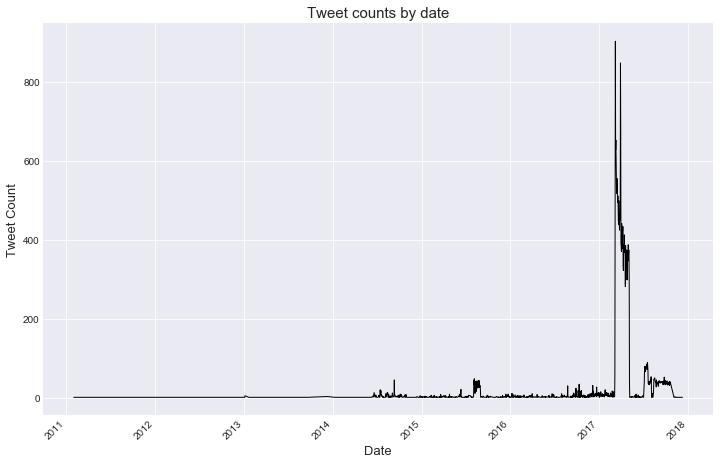

In [68]:
plt.style.use('seaborn-darkgrid')
times['tot'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.show()

We observe a period of exceptional activity in the first months of 2017. These corresponded to months of political tension across Europe due to the presence of numerous terrorists' attacks: London, Stockholm, Paris, St Petersburg, Manchester were among the cities which witnessed these attacks. The idea is that one of the challenges Europe is facing is how to deal with immigration and its consequences. Populist parties tend to answer to this issue in a simplistic way, refusing immigration in all its forms. Of course Russian trolls would use the rise of Islamic terrorism as a sign of the difficulties of Europe and as a way to support the messages of populist parties.

Wenow zoom in on the other months and look for further evidence of the divisive strategy of trolls.

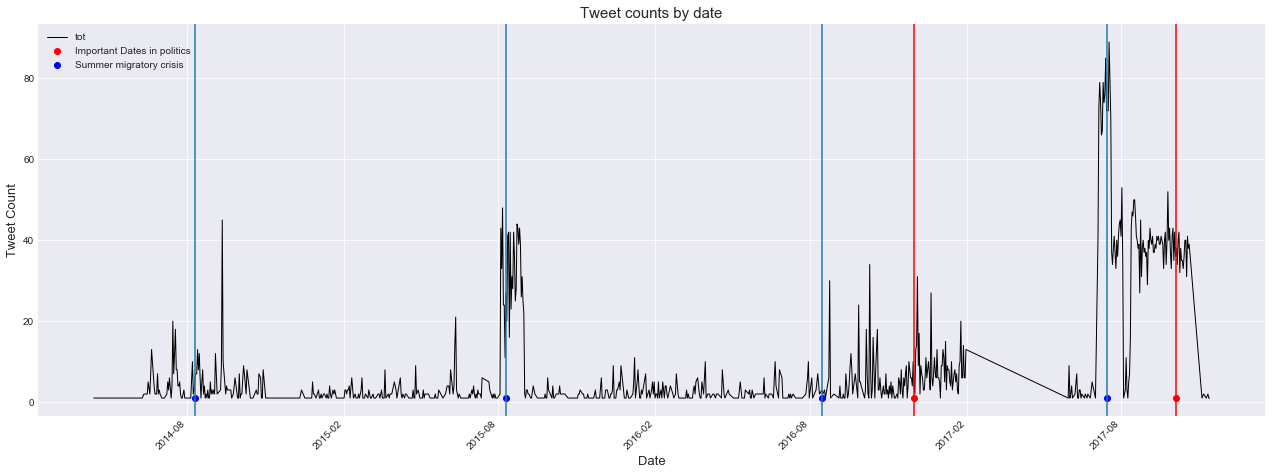

In [69]:
peak=ita_tweets[['content','author','time']]
peak=peak[peak['time'].apply(lambda x:
                         ((x<datetime.strptime('01-02-2017', '%d-%m-%Y') or 
                          (x>datetime.strptime('31-05-2017', '%d-%m-%Y'))) & 
                          (x>datetime.strptime('01-03-2014', '%d-%m-%Y')) & 
                          (x<datetime.strptime('15-11-2017', '%d-%m-%Y')))
                        )]
peak['time']=peak['time'].apply(lambda x: x.date())#authors.head()
peak['time'] = pd.to_datetime(peak['time'])
peak=peak.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
peak.sort_values(by='time', ascending = True, inplace = True)
peak=peak.set_index('time')

dates_list = ['2016-12-01','2017-10-05']
# 08-2017
# March-May 2017 terror attacks in Europe: London, Stockholm, Paris, St Petersburg, Manchester
# 12-2016 Italian referendum
# 08-2015 Migratory crisis in Europe
# 05-2014 European elections
important_dates = pd.Series(pd.to_datetime(dates_list))

summer = ['2017-07-15','2016-08-15','2015-08-10','2014-08-10']
summer_dates = pd.Series(pd.to_datetime(summer))

# add columns to identify important events, and mark a 0 or 1.
peak['Summer Events'] = False
peak.loc[summer_dates, 'Summer Events'] = True
peak['vals'] = 0
peak.loc[summer_dates, 'vals'] = 1

peak['Important Events'] = False
peak.loc[important_dates, 'Important Events'] = True
peak['values'] = 0
peak.loc[important_dates, 'values'] = 1

plt.style.use('seaborn-darkgrid')
peak['tot'].plot(linestyle = "-", figsize = (22,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.plot(peak[peak['Important Events'] == True].index.values,
         peak.loc[peak['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in politics')

plt.plot(peak[peak['Summer Events'] == True].index.values,
         peak.loc[peak['Summer Events'] == True, 'vals'],
         marker = 'o', 
         color = 'b',
         linestyle = 'none',
        label = 'Summer migratory crisis')

for m in peak[peak['Summer Events'] == True].index.values:
    plt.axvline(x=m)
    
for m in peak[peak['Important Events'] == True].index.values:
    plt.axvline(x=m, color='r')

plt.legend(loc = 'best')

plt.show()

We highlighted:

1. migratory crisis;

2. the Italian constitutional referendum, whose outcome was one of the main causes of the fall of the centre-left party;

3. the build-up to the general elections.

Again we report some tweets to confirm our intuition.

In [33]:
tweets['time'] =  pd.to_datetime(tweets['time'], format='%Y/%m/%d %H:%M')

In [80]:
event2015= tweets[tweets['time'].apply(lambda x:((x<datetime.strptime('01-12-2015', '%d-%m-%Y')) and (x>datetime.strptime('30-04-2015', '%d-%m-%Y'))))]
event2015=event2015[event2015['content'].apply(lambda x: 'traf' in x.lower())]
print('Tweet:\n')
print(event2015.reset_index().loc[4,'content'])
print('\n')

Tweet:

RT @FedericaMog: 7 ottobre parte fase 2 operazione UE contro trafficanti. Visita oggi a HQ a Roma. Già 15 fermati e 2.146 vite salvate http…




In [35]:
# Migration
migration=tweets[tweets['content'].apply(lambda x: 'migra' in x.lower())]
migration2016=migration[migration['time'].apply(lambda x:((x<datetime.strptime('01-11-2016', '%d-%m-%Y')) and (x>datetime.strptime('30-04-2016', '%d-%m-%Y'))))]
print('Tweet:\n')
print(migration2016.reset_index().loc[0,'content'])

Tweet:

RT @semprecontro: .. attente donne, arrivano i migranti. https://t.co/ViVNSEv1yW


In [37]:
migration2017= migration[migration['time'].apply(lambda x:((x<datetime.strptime('01-11-2017', '%d-%m-%Y')) and (x>datetime.strptime('30-04-2017', '%d-%m-%Y'))))]
migration2017 = migration2017[migration2017.author == '1LORENAFAVA1'].reset_index()
print('Tweet:\n')
print(migration2017.loc[6,'content'])
print('\n')
print('Tweet:\n')
print(migration2017.loc[5,'content'])
print('\n')

Tweet:

"Italia non può ospitare tutti i migranti", pm #Catania in audizione al #Senato https://t.co/cAUDQpYaIN https://t.co/zfY9ZA0jVW


Tweet:

Migranti, @matteosalvinimi: "Spero in pulizie di massa in tutte le periferie" https://t.co/GlJ8MePnU5 https://t.co/XNMWFW97kY




In [78]:
# 12-2016 Italian referendum
referendum= tweets[tweets['time'].apply(lambda x:((x<datetime.strptime('01-01-2017', '%d-%m-%Y')) and (x>datetime.strptime('01-11-2016', '%d-%m-%Y'))))]
referendum= referendum[referendum['content'].apply(lambda x: 'refe' in x.lower())]
print('Tweet:\n')
print(referendum.reset_index().loc[3,'content'])
print('\n')
print('Tweet:\n')
print(referendum.reset_index().loc[0,'content'])
print('\n')

Tweet:

RT @danilosantini65: #Referendum o meno con #TrumpPresidente questa #UE sparirà ,lui contrario ad appoggiare manie di conquista #lobby #fin…


Tweet:

RT @Piovegovernolad: LA BASTONATA DELLA ANNUNZIATA: "PERCHÉ VOTO NO AL REFERENDUM" - https://t.co/dqLcxtS5LD https://t.co/CeSdfd5utv




In [79]:
# 08-2017
# March-May 2017 terror attacks in Europe: London, Stockholm, Paris, St Petersburg, Manchester
terrorism= tweets[tweets['time'].apply(lambda x:((x<datetime.strptime('31-12-2017', '%d-%m-%Y')) and (x>datetime.strptime('01-01-2017', '%d-%m-%Y'))))]
terrorism= terrorism[terrorism['content'].apply(lambda x: 'terro' in x.lower())]
terrorism_gatt = terrorism[terrorism.author == 'GATTISILGATTI']
print('Tweet:\n')
print(terrorism_gatt.reset_index().loc[13,'content'])
print('\n')
print('Tweet:\n')
print(terrorism_gatt.reset_index().loc[22,'content'])
print('\n')

Tweet:

Armato di coltelli nella zona dei palazzi del potere di Londra, fermato è accusato di “terrorismo”: E' accusato di… https://t.co/GQyVysE2Oq


Tweet:

Paura terrorismo, espulsi dall'Italia due marocchini e un siriano https://t.co/dRDjwBbMsP




As we can see tweets confirm our analysis with respect to 2015, 2016 and 2017, but they don't confirm our analysis about 2014. So we decide to remove it in the final presentation. 

**Conclusion**

> Three patterns emerge from the time analysis:

> 1. intense activity during the summer months: these are the times when Italy is heavily affected by migratory crisis. Further analysis shows that migration is one of the top themes picked by trolls, and one which contributes to the rise of left-wing political party *League*;

> 2. high activity during significant political events: the constitutional referendum in 2016 and the weeks leading up to the General Elections at the beginning of 2018. This is coherent with IRA's intention to influence political results;

> 3. high activity in the months March-May 2017: troll might have wanted to stress the climate of instability in Europe and spur rage against Islam, giving rise to populist attitudes in European countries.


> If, as we claim, Russian trolls aim at spurring political instability in Europe, it is natural that they should focus on disruptive events showing the weaknesses of our society. Also, they would be likely to touch upon themes that are key in the political agenda of populist parties (*Leaugue* and *Five-Star Movement*), making Europe more frail and threatening the stability of international relationships. They would naturally encourage political debate, creating divisiveness in the country.

> What we see is indeed that they are more active during periods coinciding with peaks of terrorism in Europe, migratory crisis and political events.

# 2. Data Mining

In this section we exploit some data mining technique to explore recurring themes, frequent words, and words often appearing together.

Some key points emerged in the previous discussion about trolls. Will they find a correspondence in the following analysis?

For the sake of clarity, we review the main ideas collected until now and present expected related results.

1. Trolls showed mixed strategies in terms of account size (followers and following) and activity (number of tweets produced): on the same line, we expect to see that a broad variety of topics is touched by trolls, to engage as vast a public as possible; <br/>

2. peaks of activity during particular periods, especially when it comes to delicate occurrences (terror attacks), major political events or crisis: we expect that in the wide range of themes emerging from the discussions, a prominent role is played by political facts and social problems;

3. particularly relative high mentions to some regions, which brodaly coincide with those whose political centre of mass was shifting towards populist parties: we expect that themes frequently addressed by these parties are also touched by trolls.

The starting point is as usual the retrieval of our tweets.

In [76]:
ita=ita_tweets[['content','author','time']]
regex = re.compile('[^a-zA-Z ]')
def returntest(text):
    text=text.lower()
    text=regex.sub('',text) 
    text=re.sub(r'(\s)http\w+', r' ', text)
    return text
new_text = ita.content.apply(returntest)
print(new_text.head(1))
new_text.to_csv("tweets_ita.csv")

649    mi sono ricordata che oggi  lotto di marzo sol...
Name: content, dtype: object


In [86]:
italian_tweets_text = pd.read_csv('tweets_ita.csv',header=None)
print(italian_tweets_text.shape)


(34015, 2)


Note that we decide to ignore smaller words, but we still keep *pd* and *ms*, which stand for *Democratic Party* and *Five-Star Movement*.

In [79]:
list_final = []
for text in italian_tweets_text[1]:
    list_final.append([word.lower() for word in text.split() 
                       if (word.lower() not in stopwords and
                           (len(word)>3 or word in ['pd','ms']))])

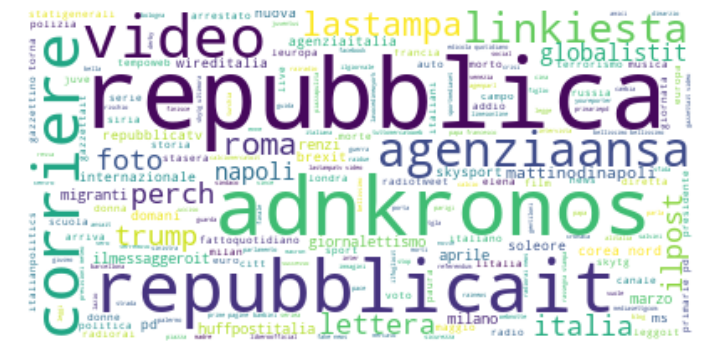

In [80]:
text = " ".join([word for tweet in list_final for word in tweet])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud highlights a macroscopic feature of the trolls' strategy, namely the willingness to refer to well-known and recognised newspapers and agencies when spreading news events. The most cited ones are 

    * la Repubblica,
    * Corriere della Sera,
    * La Stampa,
    * ANSA,
    * AD Kronos.
    
The fact that these sources are generally considered to be reliable by a large share of the population, and are definitely the most popular, would confirm the thesis by which trolls would try to engage a wide range of followers and to present themselves as reliable, and, in general, by no means extremist.

We now filter out the names of the main Italian papers and agencies, to see whether further intuitions emerge from the tweets' collection: the list of papers cannot be exhaustive, but combines the one offered by [Wikipedia](https://it.wikipedia.org/wiki/Quotidiani_in_Italia) with our personal knowledge.

In [1]:
papers=['Corriere della Sera','repubblica','repubblicait','SoleORE','QuotidianoNazionale',
        'Gazzettait','laStampa','ilMessaggeroit','quotidianonazionale','ilpost',
        'corriere','ilgiornale','Avvenire','Tuttosport','libero','leggoit',
        'FattoQuotidiano','Mattinodinapoli','huffpost','linkiesta',
        'adnkronos','agenziaansa','video','giornalettismo','ilpost',
        'lettera','huffpostitalia','agenziaitalia','skytg','skysport','internazionale',
        'perch','foto','repubblicatv','wireditalia','news','diretta','leggo','radiorai']
papers=[m.lower() for m in papers]
for el in list_final:
     if el in papers:
            list_final.remove(el)
text = " ".join([word for tweet in list_final for word in tweet if word not in papers])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: name 'list_final' is not defined

Following what was being discussed in previous points, we start by stressing that trolls strive not to be monothematic. Although, as expected, the main words relate to politics, a more careful observation shows the presence of:

    * music,
    * football (Juve, Milan),
    * weather forecasts,
    * history,
    
More interesting to trolls, however are socio-political issues: we try to provide possible explanations of why some words might be appearing, in the light of previous hypothesis and of the current global context.

* **National Politics**
    * Grillo, Renzi, Salvini, Gentiloni (Italian Prime Minister, 2016-2018).
    * *primarie*: vote to nominate the leader of a party.
    * consip
    * referendum, elections
    * left (but not right...)
    * migrants, police, security
    * earthquake
    
    National politics seem to be dominated by the problems internal to the centre-left party (PD): few words seem to refer to the operations of the government, while the majority of mentions seem to be related to the crisis of the Democratic Party (the *referendum* which lead to the fall of the Party, the *primarie* to find the leader of *PD*, the scandal of CONSIP, which concerned people close to Matteo Renzi,...). 

    At the same time there is a wide reference to topics, such as security and migrants, which have dominated the electoral campaign in 2018 and are still the main reason why the *League* popularity seems unstoppable.
    
    
* **International Politics**
    * Brexit, Euro and Europe,
    * casualties, deaths, injured, die, dead,
    * fear, terror, risk, terrorism, massacre, attack,
    * France, Germany,
    * war,
    * Russia, Syria, Turkey,
    * Trump.
    
    As mentioned in previous sections, topics in international politics mainly concern weaknesses of the European Union: terror attacks, Brexit, the common currency... The lexicon seem to be dominated by negative words, which conveys the idea of the current situation in Europe as doomed. But there is more to it. Except for Germany and France, the countries mentioned have one common feature: they are ruled by authoritarian leaders: Erdogan, Assad, Putin. Of course, a similar idea holds for Trump, which is typically perceived as strong and tough, especially in terms of migration. 
    
    Also, notice that Syria is the one of the main interests of the Russian foreign politics.
    


In [83]:
#wordcloud.words_

### Retweet Analysis

In [5]:
# Read the new italian_tweets dataset:
initial_tweets = pd.read_csv('italian_tweets_notestados.csv')
# Only keep the tweets which were created by authors themselves:
originalTweets= initial_tweets.loc[initial_tweets['is_retweet']==False]
# Sort those tweets accoridng to their retweet_count:
originalTweets_count = originalTweets.sort_values(by = 'retweet_count',ascending=False)

In [6]:
# Filter all tweets with at least one retweet:
original_RT_Tweets = originalTweets_count.loc[originalTweets_count['retweet_count']>0]
original_RT_Tweets[['retweet_count']].describe()

,retweet_count
count,284.000000
mean,11.038732
std,52.943018
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,731.000000


The most popular tweet in this dataset has 731 times'retweet. On average, each tweet was retweeted 11 times.

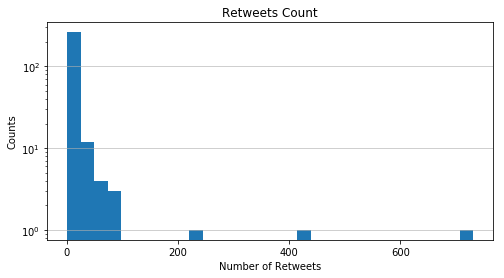

In [7]:
plt.figure(figsize=(8,4))
plt.hist(original_RT_Tweets.retweet_count,bins=30,log=True)
plt.xlabel('Number of Retweets')
plt.ylabel('Counts')
plt.title(r'Retweets Count')
plt.grid(axis='y', alpha=0.75)
plt.locator_params(axis='x',nbins=6)

plt.show()

From the plot above, we can find that most tweets are retweeted with <100 times. Next we are going to analyze the most frequent word in those tweets with retweets.

In [14]:
list_final = []
for text in original_RT_Tweets['tweet_text']:
    list_final.append([word.lower() for word in text.split() 
                       if (word.lower() not in stopwords and ("http" not in word.lower()) and
                           (len(word)>3))])

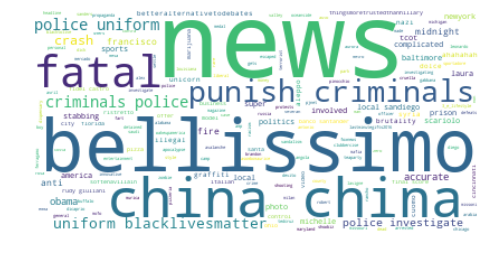

In [15]:
text = " ".join([word for tweet in list_final for word in tweet])
wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From the wordcloud figure above, we can find out the most frequent words in those tweets are: news, bellissimo(which means 'lovely' in English), china, fatal, punish criminals, blacklivesmatter a

## Clustering

In [87]:
# Retrieve the set of tweet text
initial_tweets = pd.read_csv('final_df.csv').iloc[:,1:]
stopwords = stopwords[0].tolist()

In [125]:
documents=initial_tweets['content'].tolist()
documents=[re.sub(r'(\s)http.+', r'', m.lower()) for m in documents]
len(documents)

34015

In [136]:
documents_trial = documents[15000:30000]


In [137]:
%%capture
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(documents_trial)

In [138]:
dist = 1 - cosine_similarity(X)

In [139]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=5)
data = model.fit(X)

In [140]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
common_words = model.cluster_centers_.argsort()[:,-1:-21:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(terms[word] for word in centroid))

Top terms per cluster:
0 : video, più, italia, gt, roma, renzi, pd, foto, perché, napoli, macron, europa, milano, aprile, alitalia, blog, ue, nuova, così, migranti
1 : rt, adnkronos, repubblica, repubblicait, elena07617349, corriere, più, bellissimo, video, roma, leggoit, agenzia_ansa, italia, gt, lastampa, ilpost, calciomercatoit, linkiesta, agenzia_italia, skytg24
2 : trump, usa, corea, nord, rt, siria, bianca, repubblica, muro, pyongyang, minaccia, test, russia, guerra, cina, attacco, missili, 100, nucleare, obama


In [141]:
pca = PCA(n_components=10)

principalComponents = pca.fit_transform(dist)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2',
                          'principal component 3', 'principal component 4',
                          'principal component 5', 'principal component 6',
                          'principal component 7', 'principal component 8',
                          'principal component 9', 'principal component 10'])

a = principalDf.iloc[:,0]
b = principalDf.iloc[:,1]
c = principalDf.iloc[:,2]
d = principalDf.iloc[:,3]
e = principalDf.iloc[:,4]
f = principalDf.iloc[:,5]
g = principalDf.iloc[:,6]
h = principalDf.iloc[:,7]
i = principalDf.iloc[:,8]
j = principalDf.iloc[:,9]

In [142]:
clusters = model.labels_.tolist()
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

#set up cluster names using a dict
cluster_names = {0: 'National Politics', 
                 1: 'Newspapers', 
                 2: 'International Politics'}

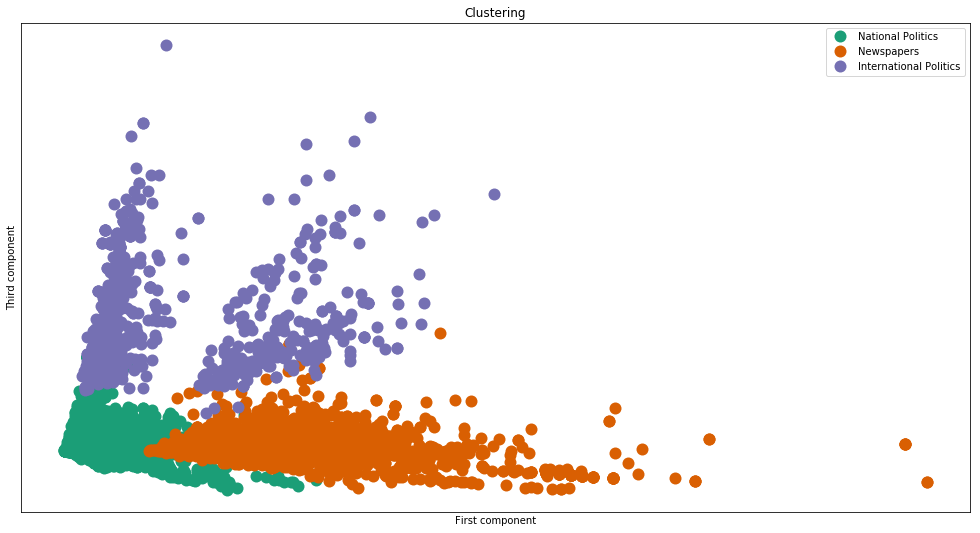

In [157]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=a, y=c, label=clusters)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  
ax.set_xlabel("First component")
ax.set_ylabel("Third component")
ax.legend(loc="best")
ax.set_title("Clustering")
    
    
plt.show() #show the plot

## Association Rules

We know try to get a closer look by applying data mining techniques to the collection of tweets. We start by association rules, to see which words often come together.

In [276]:
te = TransactionEncoder()
te_ary = te.fit(list_final).transform(list_final)
df = pd.DataFrame(te_ary,columns=te.columns_)

In [277]:
frequent_items = apriori(df, min_support=0.001, use_colnames=True, max_len = 2)

In [318]:
couple = frequent_items [frequent_items['itemsets'].apply(lambda x: len(x)==2)]
couple = couple.sort_values(by=['support'],ascending= False)
couple.head(2)

,support,itemsets
1096,0.005396,"(pd, renzi)"
1057,0.004954,"(corea, nord)"


In [319]:
table = association_rules(frequent_items, metric="confidence", min_threshold=0.2)
table = table.sort_values(by=['confidence'],ascending= False)

In [321]:
pd.set_option("display.max_rows",999)
table.head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
21,(carmenpiscopo),(elena),0.001388,0.00751,0.001294,0.931818,124.072765,0.001283,14.556516


To provide a more orderly visualisation, we classify the most interesting association rules based on the topic.

### National Politics

Together with the patterns described in the previous section, we now see that Beppe **Grillo**, the founder of the Five-Star Movement, is frequently associated to the world *blog*, which, in all likelihood, is a reference to the [blog](https://www.ilblogdellestelle.it) of the M5S Party. In other words, unlike other parties, it looks like when mentioning Beppe Grillo, Russian trolls also refer to the official web magazine of the Party.

Again, the Democratic Party **PD** and Matteo **Renzi** are mostly associated to the signs of the decline of the same party: the CONSIP scandal and the internal rivalries: Orlando and Emiliano were the other candidates to the secretary of the Party.

In addition, Matteo **Salvini** is associated to Napoli, the biggest city of Southern Italy: this is peculiar, Salvini being a politician that used to promise the independence of Northern Italy...

Laslty, it is significant that **law** is a significant consequent of electoral: indeed, the weakness of the Italian political system is attributed to the lack of a solid electoral law.

In [325]:
list_ids = [74,81,38,26,36,53,10,66]
important_tweets = pd.Series(list_ids)
table['vals'] = 0
table.loc[important_tweets, 'vals'] = 1
table.loc[table.vals==1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Note,vals
74,(primarie),(pd),0.004828,0.015715,0.004292,0.888889,56.564034,0.004216,8.858567,True,1
36,(elettorale),(legge),0.001641,0.006721,0.001104,0.673077,100.139942,0.001093,3.038264,True,1
66,(salvini),(napoli),0.004418,0.011108,0.001862,0.421429,37.940544,0.001813,1.709197,True,1
81,(primariepd),(renzi),0.002745,0.015052,0.001010,0.367816,24.436251,0.000968,1.558009,True,1
38,(orlando),(emiliano),0.003440,0.003881,0.001262,0.366972,94.547624,0.001249,1.573579,True,1
26,(consip),(renzi),0.003503,0.015052,0.001041,0.297297,19.751261,0.000989,1.401657,True,1
53,(grillo),(ms),0.004165,0.008173,0.001136,0.272727,33.369603,0.001102,1.363762,True,1
10,(grillo),(blog),0.004165,0.008110,0.001104,0.265152,32.695142,0.001071,1.349789,True,1


### International Politics

While in the Word Cloud representation we had focused on the European situation, association rules shed light on the global context, and particularly to the North Korean and Syrian issues. The words **missiles** are associated to both **Syria** and **Korea**, which is in turn associated to *North*.

**Putin** is featured as the antecedent of **Trump**: although the relation between the two countries experiences ups and downs, the two men share similar personal characteristics. 

Lastly, we want to stress the pair **Le Pen**, **Macron**: Le Pen is often see as the analogue of Matteo Salvini in France, while parallels have been drawn between Renzi and Macron (in spite of some undeniable differences). Marine Le Pen is certainly making the most of the European populist wave, exactly like Matteo Salvini and together they have contributed to the erosion of traditional politcal parties.


In [326]:
inter_ids = [58,27,30,67,64,65,5,42,82,90]
inter_tweets = pd.Series(inter_ids)
table['vals_inter'] = 0
table.loc[inter_tweets, 'vals_inter'] = 1
table.loc[table.vals_inter==1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Note,vals,vals_inter
58,(lepen),(macron),0.001357,0.007005,0.001073,0.790698,112.870312,0.001063,4.744308,False,0,1
64,(missile),(nord),0.001893,0.008204,0.001483,0.783333,95.476282,0.001468,4.577518,False,0,1
27,(corea),(nord),0.007636,0.008204,0.004954,0.648760,79.073903,0.004892,2.823700,False,0,1
65,(missili),(siria),0.001830,0.009214,0.001073,0.586207,63.619509,0.001056,2.394399,False,0,1
5,(assad),(siria),0.002177,0.009214,0.001136,0.521739,56.622990,0.001116,2.071643,False,0,1
42,(erdogan),(turchia),0.003566,0.005680,0.001704,0.477876,84.132743,0.001684,1.904376,False,0,1
30,(test),(corea),0.003029,0.007636,0.001073,0.354167,46.378271,0.001050,1.536563,False,0,1
67,(test),(nord),0.003029,0.008204,0.001073,0.354167,43.167468,0.001048,1.535683,False,0,1
82,(putin),(trump),0.003471,0.023951,0.001010,0.290909,12.146125,0.000927,1.376480,False,0,1
90,(siria),(trump),0.009214,0.023951,0.002304,0.250000,10.438076,0.002083,1.301399,False,0,1


### Terrorism

It emerged from the cloud of words that Russian trolls had a particular leaning towards dramatic representations of the current context. The following rules are among the possible examples of the fact that even well-known cities mainly have an echo in the troll dataset because of terror attacks. 

It is the case, for instance, of the 2007 islamist terror attack at **Westmister, London**, which had 6 deaths and 49 injuries (see [here](https://en.wikipedia.org/wiki/2017_Westminster_attack)), or **Stockholm**, where a truck (*camion* in Italian) caused 5 deaths (check [here](https://en.wikipedia.org/wiki/2017_Stockholm_truck_attack)).

We also report two other interesting pairs: **at least** often goes with **deaths**, and **deaths** in turn often go with **injuries**.

In [327]:
terror_ids = [60,2,17,45]
terror_tweets = pd.Series(terror_ids)
table['vals_inter'] = 0
table.loc[terror_tweets, 'vals_terror'] = 1
table.loc[table.vals_terror==1]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Note,vals,vals_inter,vals_terror
60,(westminster),(londra),0.001736,0.008804,0.001325,0.763636,86.737048,0.001310,4.193521,False,0,0,1.0
2,(almeno),(morti),0.003755,0.010035,0.001483,0.394958,39.359178,0.001445,1.636193,False,0,0,1.0
17,(stoccolma),(camion),0.002651,0.001641,0.001041,0.392857,239.416209,0.001037,1.644356,False,0,0,1.0
45,(morti),(feriti),0.010035,0.007731,0.002020,0.201258,26.032088,0.001942,1.242289,False,0,0,1.0


In [314]:
def draw_graph(rules, rules_to_show,strs):
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N)       
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
    
    for node in G1:
        found_a_string = False
        
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('red')       
 
 
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    
    nx.draw_networkx_labels(G1, pos)
    plt.show()

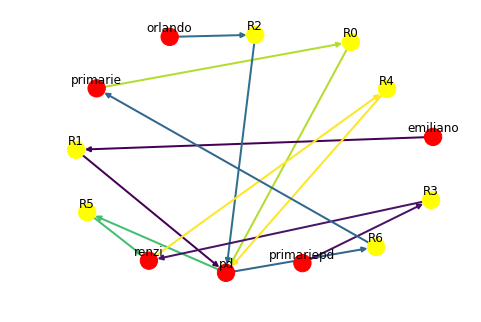

In [313]:
pd = table[(table['antecedents'].apply(lambda x: 'pd' in str(x))) |
             (table['consequents'].apply(lambda x: 'pd' in str(x)))]
#print(pd)
strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6']
draw_graph(pd, 7, strs)  

## Sentiment Analysis

In [105]:
# Retrieve the set of tweet text
initial_tweets = pd.read_csv('final_df.csv').iloc[:,1:]

In [106]:
def clean_tweet(tweet):
    '''
    Clean the text in a tweet by removing links and special characters using regex.
    '''
    tweet_nolink = re.sub(r'(\s)https\w+', r'', tweet.lower())
    
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet_nolink).split())

In [108]:
to_lang="en"
analyzer = SentimentIntensityAnalyzer()
final_list_general= []

for tweet in initial_tweets['content']:
    tweet = clean_tweet(tweet)
    from_lang="it"
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(tweet, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    vs = analyzer.polarity_scores(translation)
    list_sentiment = [vs['neg'],vs['neu'],vs['pos'],vs['compound']]
    final_list_general.append(list_sentiment)


In [ ]:
# To store the result
df1 = pd.DataFrame(final_list_general, columns=['negative','neutral','positive','compound'])
df1.reset_index(drop=True, inplace=True)
initial_tweets.reset_index(drop=True, inplace=True)
general_sent = pd.concat([initial_tweets, df1], axis=1)
general_sent.to_csv('Sentiment.csv')

In [81]:
general_sent = pd.read_csv('Sentiment.csv').iloc[:,1:]
general_sent.columns

Index(['index', 'tweet', 'negative', 'neutral', 'positive', 'compound'], dtype='object')

In [ ]:
general_sent['time'] = pd.to_datetime(general_sent['time'], format='%Y/%m/%d %H:%M')

In [82]:
# General sentiment
general_sent.loc['Average', ['negative','neutral','positive','compound']] = general_sent[['negative','neutral','positive','compound']].mean()
print("'General sentiments:")
print(general_sent.loc['Average',['negative','neutral','positive','compound']])

'General sentiments:
negative    0.111006
neutral     0.745998
positive    0.142996
compound    0.226285
Name: Average, dtype: object


In [85]:
# Restric the dataset to the critical datetime
sent_terr=general_sent[general_sent['time'].apply(lambda x:((x<datetime.strptime('01-02-2017', '%d-%m-%Y')) or 
                            (x>datetime.strptime('31-05-2017', '%d-%m-%Y'))))]

# General sentiment
sent_terr.loc['Average', ['negative','neutral','positive','compound']] = sent_terr[['negative','neutral','positive','compound']].mean()
print("'General sentiments terrorism period:")
print(sent_terr.loc['Average',['negative','neutral','positive','compound']])

In [ ]:
# Restric the dataset to the retweet/no retweet
no_retweets_sentiment=general_sent[general_sent.retweet==0]
retweets_sentiment=general_sent[general_sent.retweet==1]

# General sentiment
no_retweets_sentiment.loc['Average', ['negative','neutral','positive','compound']] = no_retweets_sentiment[['negative','neutral','positive','compound']].mean()
print("'General sentiments no retweets:")
print(no_retweets_sentiment.loc['Average',['negative','neutral','positive','compound']])
# General sentiment
retweets_sentiment.loc['Average', ['negative','neutral','positive','compound']] = retweets_sentiment[['negative','neutral','positive','compound']].mean()
print("'General sentiments retweets:")
print(retweets_sentiment.loc['Average',['negative','neutral','positive','compound']])

# Combine Sentiment Analysis and Political Parties

In [2]:
# Retrieve the set of tweet text
initial_tweets = pd.read_csv('final_df.csv').iloc[:,1:]
tweets=initial_tweets[['content','author','time']]
tweets.head()

,content,author,time
0,Mi sono ricordata che oggi è l'otto di marzo s...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-08 15:24:00
1,Quando gli estranei fanno qualcosa di piacevol...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-08 18:13:00
2,Magnesia-O. @hardwick @midnight #SuperOldHeroes,75260a9a180575743d360235084b16675248455e83c04b...,2017-03-03 11:07:00
3,Fido-re-mi #DogSongs @midnight,75260a9a180575743d360235084b16675248455e83c04b...,2017-01-31 09:22:00
4,"L'America, L'America, L'America",10f62eab6984a76b343b1034db3fe283d4e2b8ccc37afe...,2014-08-28 06:09:00


In [41]:
renzi=tweets[tweets['content'].apply(lambda x: 'renzi' in x.lower())]
renzi_no_retweet = no_retweets_sentiment[no_retweets_sentiment['content'].apply(lambda x: 'renzi' in x.lower())]
renzi_retweet = retweets_sentiment[retweets_sentiment['content'].apply(lambda x: 'renzi' in x.lower())]

to_lang="en"
analyzer = SentimentIntensityAnalyzer()
final_list_renzi= []

for tweet in renzi['content']:
    #tweet = clean_tweet(tweet)
    from_lang="it"
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(tweet, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    vs = analyzer.polarity_scores(translation)
    list_sentiment = [vs['neg'],vs['neu'],vs['pos'],vs['compound']]
    final_list_renzi.append(list_sentiment)


In [94]:
# To store in a df
df_renzi = pd.DataFrame(final_list_renzi, columns=['negative','neutral','positive','compound'])
renzi.reset_index(drop=True, inplace=True)
df_renzi.reset_index(drop=True, inplace=True)
sentiment_renzi = pd.concat([renzi, df_renzi], axis=1)

# Example of negative tweet
#sentiment_renzi.loc[29,'content']

#print(sentiment_renzi.content)
sentiment_renzi.loc['Average', ['negative','neutral','positive','compound']] = sentiment_renzi[['negative','neutral','positive','compound']].mean()
print("'Renzi' general sentiments:")
print(sentiment_renzi.loc['Average',['negative','neutral','positive','compound']])

'Renzi' general sentiments:
negative     0.122207
neutral      0.750148
positive     0.127287
compound    0.0627349
Name: Average, dtype: object


In [74]:
salvini=tweets[tweets['content'].apply(lambda x: 'salvini' in x.lower())]
salvini_no_retweet = no_retweets_sentiment[no_retweets_sentiment['content'].apply(lambda x: 'salvini' in x.lower())]
salvini_retweet = retweets_sentiment[retweets_sentiment['content'].apply(lambda x: 'salvini' in x.lower())]

final_list_salvini= []

for tweet in salvini['content']:
    #tweet = clean_tweet(tweet)
    from_lang="it"
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(tweet, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    vs = analyzer.polarity_scores(translation)
    list_sentiment = [vs['neg'],vs['neu'],vs['pos'],vs['compound']]
    final_list_salvini.append(list_sentiment)

In [75]:
# To store in a df
df_salvini = pd.DataFrame(final_list_salvini, columns=['negative','neutral','positive','compound'])
salvini.reset_index(drop=True, inplace=True)
df_salvini.reset_index(drop=True, inplace=True)
sentiment_salvini = pd.concat([salvini, df_salvini], axis=1)
sentiment_salvini.loc['Average', ['negative','neutral','positive','compound']] = sentiment_salvini[['negative','neutral','positive','compound']].mean()
print("'Salvini' general sentiments:")
print(sentiment_salvini.loc['Average',['negative','neutral','positive','compound']])

'Salvini' general sentiments:
negative      0.1215
neutral      0.74918
positive     0.12902
compound    0.086272
Name: Average, dtype: object


In [77]:
grillo=tweets[tweets['content'].apply(lambda x: 'grillo' in x.lower())]
grillo_no_retweet = no_retweets_sentiment[no_retweets_sentiment['content'].apply(lambda x: 'grillo' in x.lower())]
grillo_retweet = retweets_sentiment[retweets_sentiment['content'].apply(lambda x: 'grillo' in x.lower())]

final_list_grillo= []

for tweet in grillo['content']:
    #tweet = clean_tweet(tweet)
    from_lang="it"
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(tweet, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    vs = analyzer.polarity_scores(translation)
    list_sentiment = [vs['neg'],vs['neu'],vs['pos'],vs['compound']]
    final_list_grillo.append(list_sentiment)

In [78]:
# To store in a df
df_grillo = pd.DataFrame(final_list_grillo, columns=['negative','neutral','positive','compound'])
grillo.reset_index(drop=True, inplace=True)
df_grillo.reset_index(drop=True, inplace=True)
sentiment_grillo = pd.concat([grillo, df_grillo], axis=1)
sentiment_grillo.loc['Average', ['negative','neutral','positive','compound']] = sentiment_grillo[['negative','neutral','positive','compound']].mean()
print("'Grillo' general sentiments:")
print(sentiment_grillo.loc['Average',['negative','neutral','positive','compound']])

'Grillo' general sentiments:
negative     0.129341
neutral      0.748629
positive     0.121653
compound    0.0364557
Name: Average, dtype: object


In [79]:
def wordInString(word, string_value):
    return True if re.search(r'\b' + word + r'\b', string_value) else False

In [80]:
lega=tweets[tweets['content'].apply(lambda x: wordInString('lega',x.lower()))]
lega_no_retweet = no_retweets_sentiment[no_retweets_sentiment['content'].apply(lambda x: 'lega' in x.lower())]
lega_retweet = retweets_sentiment[retweets_sentiment['content'].apply(lambda x: 'lega' in x.lower())]

final_list_lega= []

for tweet in lega['content']:
    #tweet = clean_tweet(tweet)
    from_lang="it"
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(tweet, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    vs = analyzer.polarity_scores(translation)
    list_sentiment = [vs['neg'],vs['neu'],vs['pos'],vs['compound']]
    final_list_lega.append(list_sentiment)

In [81]:
# To store in a df
df_lega = pd.DataFrame(final_list_lega, columns=['negative','neutral','positive','compound'])
lega.reset_index(drop=True, inplace=True)
df_lega.reset_index(drop=True, inplace=True)
sentiment_lega = pd.concat([lega, df_lega], axis=1)
sentiment_lega.loc['Average', ['negative','neutral','positive','compound']] = sentiment_lega[['negative','neutral','positive','compound']].mean()
print("'Lega' general sentiments:")
print(sentiment_lega.loc['Average',['negative','neutral','positive','compound']])

'Lega' general sentiments:
negative    0.121735
neutral     0.748181
positive    0.129831
compound     0.10317
Name: Average, dtype: object


In [82]:
democratic_party=tweets[tweets['content'].apply(lambda x: wordInString('pd',x.lower()))]
pd_no_retweet = no_retweets_sentiment[no_retweets_sentiment['content'].apply(lambda x: 'pd' in x.lower())]
pd_retweet = retweets_sentiment[retweets_sentiment['content'].apply(lambda x: 'pd' in x.lower())]
final_list_pd= []

for tweet in democratic_party['content']:
    #tweet = clean_tweet(tweet)
    from_lang="it"
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(tweet, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    vs = analyzer.polarity_scores(translation)
    list_sentiment = [vs['neg'],vs['neu'],vs['pos'],vs['compound']]
    final_list_pd.append(list_sentiment)

In [83]:
# To store in a df
df_pd = pd.DataFrame(final_list_pd, columns=['negative','neutral','positive','compound'])
democratic_party.reset_index(drop=True, inplace=True)
df_pd.reset_index(drop=True, inplace=True)
sentiment_pd = pd.concat([democratic_party, df_pd], axis=1) 
sentiment_pd.loc['Average', ['negative','neutral','positive','compound']] = sentiment_pd[['negative','neutral','positive','compound']].mean()
print("'PD' general sentiments:")
print(sentiment_pd.loc['Average',['negative','neutral','positive','compound']])

'PD' general sentiments:
negative      0.12089
neutral      0.748795
positive     0.130043
compound    0.0981563
Name: Average, dtype: object


In [84]:
M5S=tweets[tweets['content'].apply(lambda x: 'm5s' in x.lower())]
M5S_no_retweet = no_retweets_sentiment[no_retweets_sentiment['content'].apply(lambda x: 'm5s' in x.lower())]
M5S_retweet = retweets_sentiment[retweets_sentiment['content'].apply(lambda x: 'm5s' in x.lower())]
final_list_M5S= []

for tweet in M5S['content']:
    #tweet = clean_tweet(tweet)
    from_lang="it"
    api_url = "http://mymemory.translated.net/api/get?q={}&langpair={}|{}".format(tweet, from_lang, to_lang)
    hdrs ={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
           'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
           'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
           'Accept-Encoding': 'none',
           'Accept-Language': 'en-US,en;q=0.8',
           'Connection': 'keep-alive'}
    response = requests.get(api_url, headers=hdrs)
    response_json = json.loads(response.text)
    translation = response_json["responseData"]["translatedText"]
    translator_name = "MemoryNet Translation Service"
    vs = analyzer.polarity_scores(translation)
    list_sentiment = [vs['neg'],vs['neu'],vs['pos'],vs['compound']]
    final_list_M5S.append(list_sentiment)

In [85]:
# To store in a df
df_M5S = pd.DataFrame(final_list_M5S, columns=['negative','neutral','positive','compound'])
M5S.reset_index(drop=True, inplace=True)
df_M5S.reset_index(drop=True, inplace=True)
sentiment_M5S = pd.concat([M5S, df_M5S], axis=1)
sentiment_M5S.loc['Average', ['negative','neutral','positive','compound']] = sentiment_M5S[['negative','neutral','positive','compound']].mean()
print("'M5S' general sentiments:")
print(sentiment_M5S.loc['Average',['negative','neutral','positive','compound']])

'M5S' general sentiments:
negative      0.13086
neutral      0.751181
positive     0.117433
compound   -0.0229495
Name: Average, dtype: object


In [ ]:
pd.set_option('display.max_colwidth', -1)
sents=pd.read_excel('./data/sents.xlsx',header=0)
plt.rcParams.update({'font.size': 18})
fig = plt.figure()
ax = fig.add_subplot(111)
ax=sents.plot.bar(color=['#36648B', '#33A1C9', '#C6E2FF', 'black'],title='Sentiments associated to tweets')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.figure.set_size_inches(15, 10)
#plt.savefig('sents.png')
plt.show()

# Italian Appendix

In [ ]:
states=['France','Italy','Finland','United Kingdom','Germany','Sweden','Spain']
govts=[66,65,38,25,24,17,13]
colorlist=['#3399FF','black','#3399FF','#3399FF','#3399FF','#3399FF','#3399FF']
#colorlist=['black', 'red', 'green', 'blue', 'cyan']
dizion=dict(zip(states,govts))
fig = plt.figure()
plt.rcParams.update({'font.size': 16})
fig.suptitle('Number of governments 1945-2018')
plt.style.use('seaborn-white')
plt.bar(np.arange(7),govts,tick_label=states,color=colorlist)
plt.xticks(rotation='45')
plt.savefig('govts.png')
#states.plot(y='govts', kind='bar')

In [ ]:
# General Government Gross Debt in Percent of GDP
dgdp=pd.read_excel('./data/debtgdp.xlsx',sheet_name='DebtGDP',header=1)

dgdp.columns
cols=['Austria', 'Belgium', 'Finland', 'France',
       'Germany', 'Greece', 'Ireland', 'Italy', 'Latvia', 
       'Luxembourg', 'Netherlands', 'Portugal', 'Spain']
dgdp=dgdp.loc[:,cols]

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.style.use('seaborn-white')

fig = plt.figure()
ax = fig.add_subplot(111)
ax=dgdp.plot()
ax.set_title('Gross Debt in Percent of GDP')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.figure.set_size_inches(15, 10)
plt.savefig('debt.png')

plt.show()